# Part 1 - Data investigation

This notebook is part 1 of the capstone project from the [IBM AI Enterprise Workflow specialization](https://www.coursera.org/specializations/ibm-ai-workflow). The main goal here is to investigate the [data](https://github.com/aavail/ai-workflow-capstone), and communicate findings visually.

Author: Rafael da Ponte Barbosa

In [1]:
import pandas as pd
import numpy as np
import os
import re
import datetime
import matplotlib.pyplot as plt

plt.style.use('seaborn')

from application.utils.ingestion import fetch_data
from application.utils.processing import convert_to_ts

from application.utils.plot import ts_plot

%load_ext autoreload
%autoreload 2

In [2]:
data_dir = os.path.join("data","cs-train")
df = fetch_data(data_dir)

In [3]:
df.head()

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
0,United Kingdom,13085.0,28,489434,11,6.95,85048,12,2017,2017-11-28
1,United Kingdom,13085.0,28,489434,11,6.75,79323W,12,2017,2017-11-28
2,United Kingdom,13085.0,28,489434,11,2.10,22041,21,2017,2017-11-28
3,United Kingdom,13085.0,28,489434,11,1.25,21232,5,2017,2017-11-28
4,United Kingdom,13085.0,28,489434,11,1.65,22064,17,2017,2017-11-28


## Missing values

### Features

With the data loaded into a single dataframe, we start by investigating missing values.

In [4]:
## missing values summary
print("Missing Value Summary\n{}".format("-"*35))
print(df.isnull().sum(axis = 0))

Missing Value Summary
-----------------------------------
country              0
customer_id     189762
day                  0
invoice              0
month                0
price                0
stream_id            0
times_viewed         0
year                 0
invoice_date         0
dtype: int64


In [5]:
df.customer_id.isnull().sum()/len(df)

0.2328336672756564

In [6]:
df_total_year = df[['year', 'country']].groupby(['year']).count()
df_total_year.columns = ['total']

df_missing_year = df[df.customer_id.isnull()][['year', 'country']].groupby(['year']).count()
df_missing_year.columns = ['missing']

df_missing_perc = pd.concat([df_missing_year,df_total_year],axis=1)
df_missing_perc['percentage'] = df_missing_perc.missing/df_missing_perc.total
df_missing_perc

,missing,total,percentage
year,,,
2017,13468,45228,0.297780
2018,110090,522714,0.210612
2019,66204,247069,0.267958


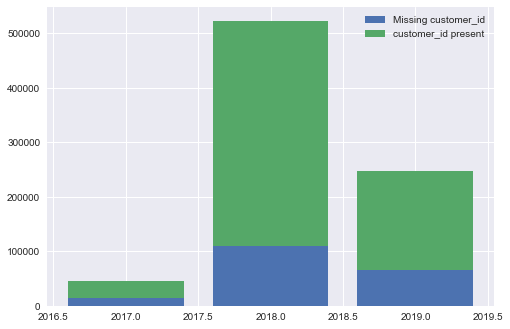

In [7]:
p1 = plt.bar(df_missing_perc.index, df_missing_perc.missing, label="Missing customer_id")
p2 = plt.bar(df_missing_perc.index, df_missing_perc.total - df_missing_perc.missing,
             bottom=df_missing_perc.missing, label="customer_id present")
plt.legend()

We see that `customer_id` is the only feature with missing values, with 189762 entries absent. This composes almost 25% of the entire dataset. We also note that the percentage of missing values remain about the same throughout the period represented in the collected data, which is between 20% and 30%.

### Dates

In [8]:
df.invoice_date.nunique()

495

In [9]:
(df.invoice_date.max() -  df.invoice_date.min()).days + 1

611

In [10]:
invoice_dates_min = df['invoice_date'].min().strftime("%Y-%m-%d")
invoice_dates_max = (df['invoice_date'].max() + datetime.timedelta(1)).strftime("%Y-%m-%d")

df_dates = df['invoice_date'].values.astype('datetime64[D]')
days = np.arange(invoice_dates_min,invoice_dates_max,dtype='datetime64[D]')

print(len(set(days).difference(df_dates)))

116


From the given dates, we also see that there are 495 unique values for `invoice_date`, but the dates span a range of 611 days, giving us 116 without any information.

## Revenue

We now analyze the revenue, our main prediction goal. From the plots below, we see that most of the revenue is coming from countries in Europe, such as the UK, EIRE, Germany and France. It is also noteworthy that the revenue in the period from the first ranked country (the United Kingdom) alone is almost 90% of the total revenue, being 32x the revenue brought by the second ranked country (EIRE).

Below, you'll find bar plots for revenue grouped by country in the period, both in the original scale and in log scale.

In [11]:
df_revenue_country = df[['country', 'price']].groupby('country').sum()
df_revenue_country.columns = ['revenue']
df_revenue_country.sort_values(by='revenue', inplace=True, ascending=False)

In [12]:
df_revenue_country[df_revenue_country.index=="United Kingdom"].revenue/df_revenue_country.revenue.sum()

country
United Kingdom    0.899677
Name: revenue, dtype: float64

In [13]:
df_revenue_country['revenue'].values[0] / df_revenue_country['revenue'].values[1]

32.89006713512097

<BarContainer object of 43 artists>

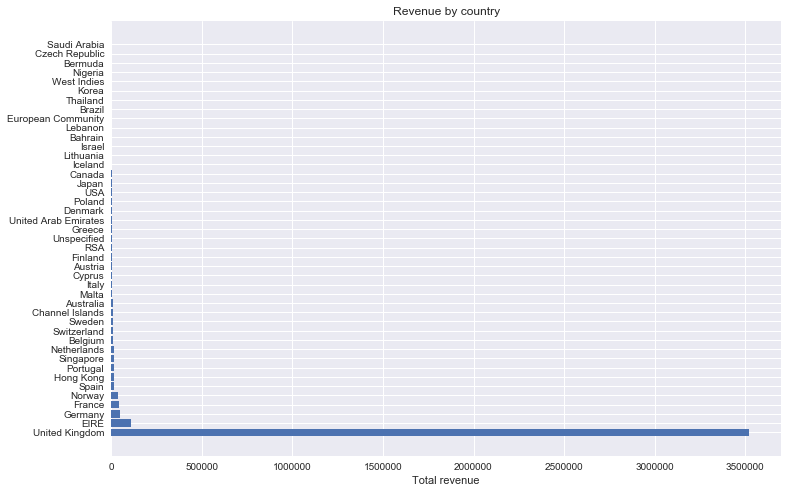

In [14]:
plt.figure(figsize=(12,8))
plt.title("Revenue by country")
plt.xlabel("Total revenue")
plt.barh(df_revenue_country.index, df_revenue_country.revenue)

<BarContainer object of 43 artists>

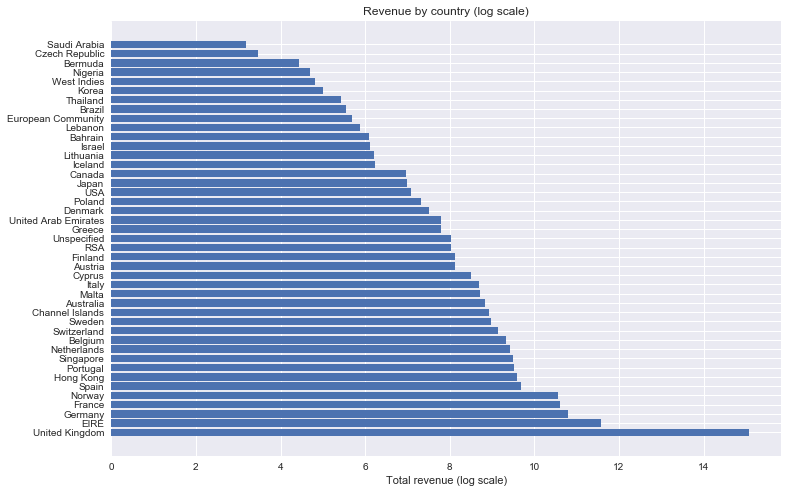

In [15]:
plt.figure(figsize=(12,8))
plt.title("Revenue by country (log scale)")
plt.xlabel("Total revenue (log scale)")
plt.barh(df_revenue_country.index, np.log(df_revenue_country.revenue))

### Time series

Let's now look at the evolution of the revenue over the months. From the graph below, we see that the revenue remains about the same throughout the period, with some increase during the end of the year. There are also 3 points where revenue is negative. We'll investigate that in the following.

In [16]:
df_ts = convert_to_ts(df)

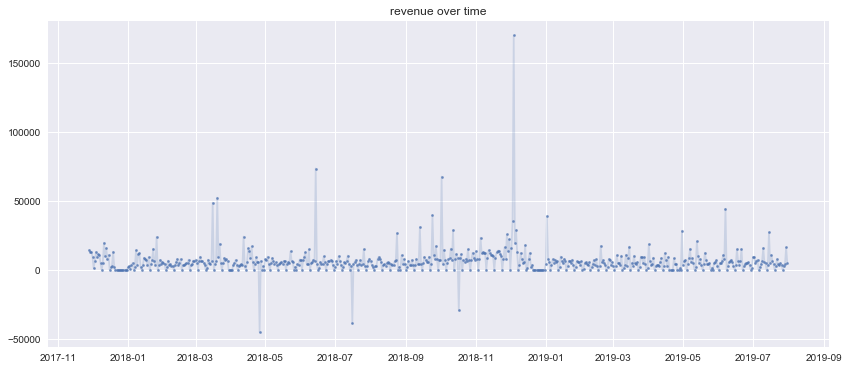

In [17]:
ts_plot(df_ts.date,df_ts["revenue"],figx=14,figy=6, title="revenue over time")

In [18]:
df_ts[df_ts.revenue<0]

,date,purchases,unique_invoices,unique_streams,total_views,year_month,revenue
149,2018-04-26,2058,106,1046,11371,2018-04,-44990.049
230,2018-07-16,1448,68,786,8907,2018-07,-38702.940
323,2018-10-17,2491,122,1092,13319,2018-10,-29374.970


In [19]:
df[(df.price<0)]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26
276274,United Kingdom,NaN,16,516228,7,-44031.79,B,1,2018,2018-07-16
403469,United Kingdom,NaN,17,528059,10,-38925.87,B,1,2018,2018-10-17


In [20]:
df[df.stream_id=="B"]

,country,customer_id,day,invoice,month,price,stream_id,times_viewed,year,invoice_date
180418,United Kingdom,NaN,26,506401,4,-53594.36,B,1,2018,2018-04-26
276274,United Kingdom,NaN,16,516228,7,-44031.79,B,1,2018,2018-07-16
403469,United Kingdom,NaN,17,528059,10,-38925.87,B,1,2018,2018-10-17


The 3 points where revenue is negative are caused by 3 negative entries (in big amounts) in the `price` column in the original dataset. All of these are indicated by `stream_id` B. 

This could possibly be due to a refund policy. If this is the case, it should be noted that less money is refunded each time, and it didn't happen for the second half of the period.

## Other features

Investigating the other features in the time series dataframe, we see a similar behavior, compared to the revenue time series: all have a large ratio of zero values, due to the missing values, as mentioned above; and all have some increase during the end of the year. 

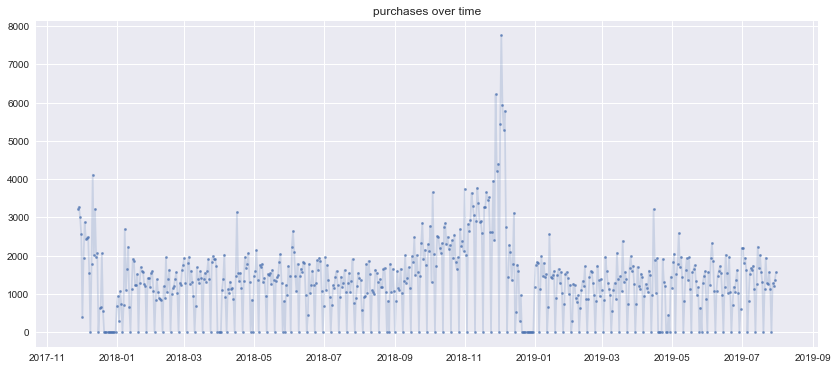

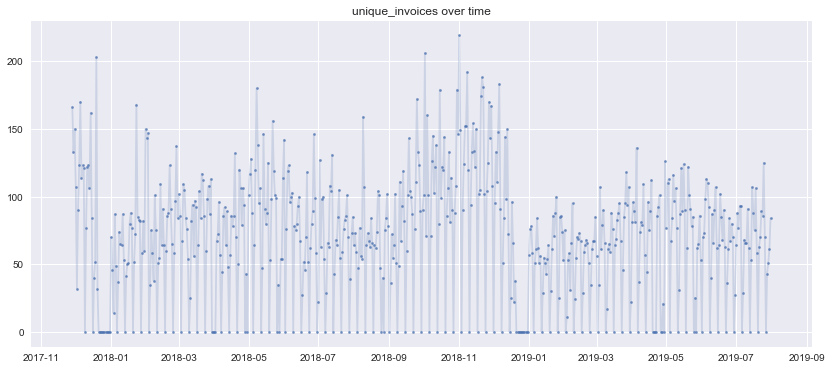

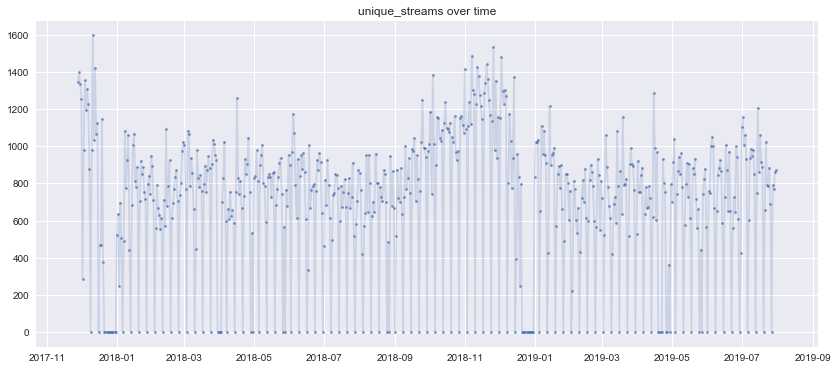

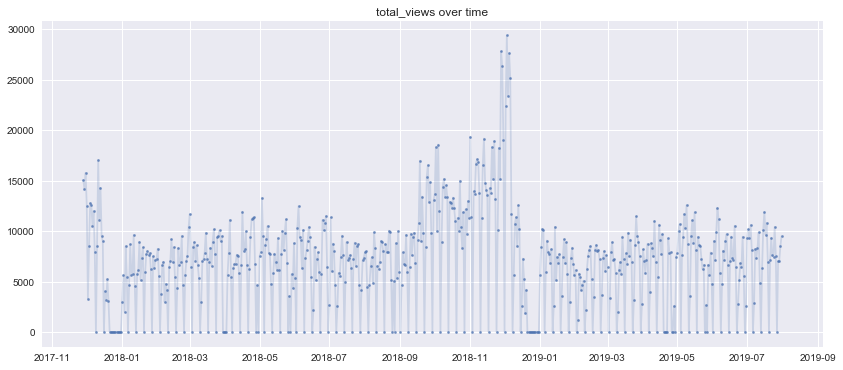

In [21]:
for col in ['purchases', 'unique_invoices', 'unique_streams', 'total_views']:
    ts_plot(df_ts.date,df_ts[col],figx=14,figy=6, title="{} over time".format(col))